#Identifying Fraund from Enron Email

<em><small>Uirá Caiado. June 21, 2015</small></em>

----------

###Abstract

I explore the public Enron financial and email dataset to identify Enron Employees who may have committed fraud. My goal is to build a machine learning algorithm to solve this chalange.

###Introduction

According to <a href="https://en.wikipedia.org/wiki/Enron">Wikipedia</a>, Enron was an energy, commodities, and services company that had employed approximately 20,000 staff. It was one of the largest companies in the United States, with claimed revenues of nearly $111 billion during 2000.

Also, it was one of the largest business scandals in American history, falling into bankruptcy in 2001 after was revealed widespread corporate fraud. As pointed out in the Udacity <a href="https://docs.google.com/document/d/10GYepNkDj-Kc_Sf6to3WX_q_SdymPOBJf3H-pq7a62g/pub">project description</a>, in the resulting Federal investigation, there was a significant amount of typically confidential information entered into the public record, including emails and financial data for top executives.

Given that there is a list of people who were somewhat involved in the scandal, here called person of interest (POI), I will try to develop a machine learning algorithm to identify those people with an acceptable accuracy.

###Understanding the Dataset

####Summarizing the dataset

The data set is relatively small, and the number of identified POIs is even smaller. There are 146 different data points, or people, in this collection, but just 18 were classified as POIs. Each data point has 21 features, although more than half of these features didn't display any information for 40% or more of all dataset, as shown below.

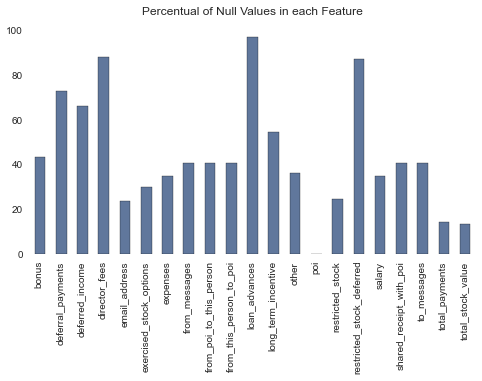

In [85]:
stats.NanAtFetaures()

Related to the features, I can categorize them into four groups:
- *Metadata*: 2 in total. If it is POI and email address. POI is what I want to predicted
- *Payments*: 10 in total. One is the summation and others are Salary, Bonus...
- *Stock Value*: 4 in total. One is also summation. for instance, Restricted stock options, Excercise stock options...
- *Emails*: 5 in total. Examples are "from POI to this person", "from messages"...

According to the documentary [The smartest guys in the room](https://www.youtube.com/watch?v=pRWXW87YrlM), the executives involved in the scandal used to exercise their option positions early. Later I will check if it can be a useful to identify POIs. Also, I don´t know if I will use the summations in Payments and Stock Value features. Maybe to look for outliers or to build new features. Excluding the both features, the POI features (that is the target) and the email address, it leaves me with 18 features to use.

Despite all the missing data, it still would be complex to analyze all possible correlations between these features. Here is where machine learning (ML) comes to play. Quonting this [book](http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1782161406), ML teaches machines how to carry out tasks by themselves, providing them with a couple of examples.

####Outlier Investigation

The point here is those examples mentioned. They should be VALID examples if I want to build a good estimator or classifier. Then, first of all, I need to look for outliers. Let's check it by looking some of the features.

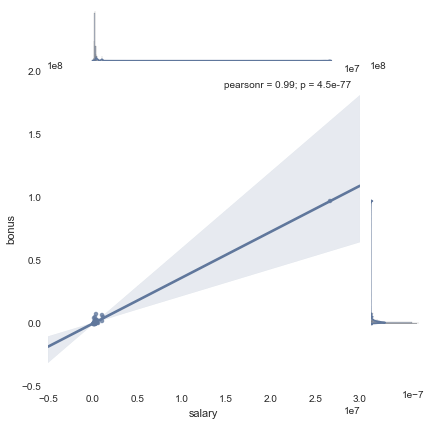

In [85]:
stats.scatter("salary", "bonus")

Here can be easily visualized that there is some data far away from the most of the data points. First, I am going to check who is in the top 10% of the "salary" feature.


In [86]:
stats.getDecile('salary')

,salary,poi
TOTAL,26704229,False


Hm... a summation. I will exclude this data point and run the scatter plot again 

In [87]:
df = stats.getData()
df.drop("TOTAL", inplace= True)
stats.setData(df)

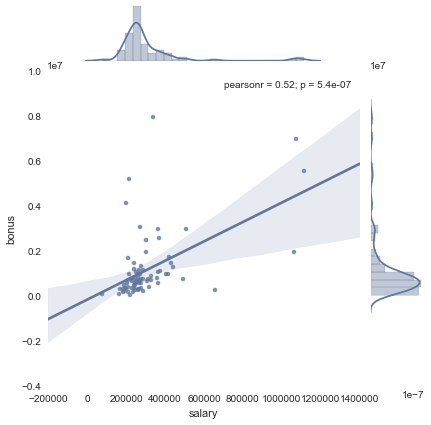

In [88]:
stats.scatter("salary", "bonus")

Much better. Looking at the last decile of each feature, I can see that neither salary or bonus seems hold real outliers.The biggest bonus wasn't to a POI.

In [89]:
stats.getDecile('salary')

,salary,poi
SKILLING JEFFREY K,1111258,True


In [90]:
stats.getDecile('bonus')

,bonus,poi
LAVORATO JOHN J,8000000,False


Well... Let's look if there is another outlier. First, I will use the summations to check other features. Any difference between the values I will show in a line called "Delta".

In [91]:
df1, df2 = stats.checkSummation()
#checking Stocks feature
df1

,BELFER ROBERT
poi,0
restricted_stock,0
restricted_stock_deferred,44093
exercised_stock_options,3285
total_stock_value,-44093
Delta,91471


In [92]:
#checking Payments features
df2

,BELFER ROBERT,BHATNAGAR SANJAY
poi,0,0
bonus,0,0
deferral_payments,-102500,0
deferred_income,0,0
director_fees,3285,137864
expenses,0,0
loan_advances,0,0
long_term_incentive,0,0
other,0,137864
salary,0,0


I can see that the differences above are due to some missing information, looking at the enron61702 pdf file. As both are non-POIs, I will exclude them.

In [93]:
df = stats.getData()
df.drop(["BELFER ROBERT","BHATNAGAR SANJAY"], inplace= True)
stats.setData(df)

Ok, now I am going to plot a description of all numeric data to see if there is any evidence of another outlier.

In [94]:
stats.describe()

,count,mean,std,min,25%,50%,75%,max
bonus,81.00,"1,201,773","1,441,679","70,000","425,000","750,000","1,200,000","8,000,000"
deferral_payments,37.00,"867,119","1,297,344","7,961","85,430","227,449","875,307","6,426,990"
deferred_income,48.00,"-581,050","942,076","-3,504,386","-611,209","-151,927","-37,926",-833
director_fees,14.00,"92,573","34,475","17,500","99,400","106,164","111,694","125,034"
exercised_stock_options,99.00,"2,993,007","5,547,033","9,803","549,008","1,297,049","2,416,963","34,348,384"
expenses,94.00,"54,192","46,108",148,"22,479","46,548","78,408","228,763"
from_messages,85.00,616,"1,851",12,22,41,146,"14,368"
from_poi_to_this_person,85.00,66,87,0,10,35,74,528
from_this_person_to_poi,85.00,42,101,0,1,8,25,609
loan_advances,3.00,"27,975,000","46,382,560","400,000","1,200,000","2,000,000","41,762,500","81,525,000"


Although there are pretty big numbers in the financial information, they are all related to executives from Eron. I guess that I am done here.

###Feature Selection and Engineering

1. What features did you end up using in your POI identifier, and what selection process did you use to pick them?  Did you have to do any scaling?  Why or why not?  As part of the assignment, you should attempt to engineer your own feature that doesn’t come ready-made in the dataset--explain what feature you tried to make, and the rationale behind it.  (You do not necessarily have to use it in the final analysis, only engineer and test it.)  If you used an algorithm like a decision tree, please also give the feature importances of the features that you use.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]

###Pick and Tune an Algorithm

1. What algorithm did you end up using?  What other one(s) did you try? [relevant rubric item: “pick an algorithm”]
2. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm?  (Some algorithms don’t have parameters that you need to tune--if this is the case for the one you picked, identify and briefly explain how you would have done it if you used, say, a decision tree classifier). [relevant rubric item: “tune the algorithm”]

###Evaluation

1. What is validation, and what’s a classic mistake you can make if you do it wrong?  How did you validate your analysis?  [relevant rubric item: “validation strategy”]
2. Give at least 2 evaluation metrics, and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

###Reflection

####TODO:
<p>6/27/2015 - Compare the summation of Payment and Stocks Features to see if all if correctly filled</p>
<p>6/26/2015 - probably is someone important....I could plot a heat map with all datapointsand from to_poi features, splitting it between POIs and non-POIS...in another section</p>

<hr>

<em>
</em>

<em>Custom CSS</em>

In [54]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read() )

In [84]:
#changing matplotlib defaults
import eda; reload(eda);
stats = eda.Eda()
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})